In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split



from paretoset import paretoset
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, CoxPHFitter
from plots import calculate_failure_rate, drop_frames_without_results, min_max_scaling
import matplotlib 
import argparse
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

In [2]:
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
FOLDER = Path("output/plots/")
csv_file = FOLDER / "data.csv"
data = pd.read_csv(csv_file, index_col=0)
data.columns = data.columns.str.strip()
data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data.def_value.replace("", 0, inplace=True)
data.atk_value.replace("", 0, inplace=True)
data = drop_frames_without_results(data)
data = calculate_failure_rate(data)
data = min_max_scaling(data)
data.dropna(axis=0, subset=['atk_value', 'atk_param'], inplace=True)
data.dropna(axis=0, subset=['def_value', 'def_param'], inplace=True)
# data=data[data['def_gen'] == 'Gauss-in']
# data=data[data['atk_gen'] == 'HSJ']

print(
    "Adversarial Accuracy:", "\n",
    "ResNet152:", data[data['model_layers'] == 152].adv_accuracy.mean(skipna=True), "\n",
    "Resnet101:", data[data['model_layers'] == 101].adv_accuracy.mean(skipna=True), "\n",
    "Resnet50:", data[data['model_layers'] == 50].adv_accuracy.mean(skipna=True), "\n",
    "Resnet34:", data[data['model_layers'] == 34].adv_accuracy.mean(skipna=True), "\n",
    "Resnet18:", data[data['model_layers'] == 18].adv_accuracy.mean(skipna=True), "\n",
)



Adversarial Accuracy: 
 ResNet152: 0.08431102362204726 
 Resnet101: 0.08595785440613028 
 Resnet50: 0.09093333333333335 
 Resnet34: 0.08867549668874172 
 Resnet18: 0.07971698113207548 



In [4]:

def plot_aft(
    df,
    file,
    event_col,
    duration_col,
    title,
    mtype,
    xlabel=None,
    ylabel=None,
    replacement_dict={},
    **kwargs,
):
    if mtype == "weibull":
        aft = WeibullAFTFitter(**kwargs)
    elif mtype == "log_normal":
        aft = LogNormalAFTFitter(**kwargs)
    elif mtype == "log_logistic":
        aft = LogLogisticAFTFitter(**kwargs)
    elif mtype == "cox":
        aft = CoxPHFitter(**kwargs)
    assert (
        duration_col in df.columns
    ), f"Column {duration_col} not in dataframe with columns {df.columns}"
    if event_col is not None:
        assert (
            event_col in df.columns
        ), f"Column {event_col} not in dataframe with columns {df.columns}"
    aft.fit(df, duration_col=duration_col, event_col=event_col)
    ax = aft.plot()
    labels = ax.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    ax.set_yticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    plt.show()
    return ax, aft

def plot_partial_effects(
    file,
    aft,
    covariate_array,
    values_array,
    title,
    xlabel="Covariate",
    ylabel="Failure rate",
    legend_kwargs={"loc": "upper left"},
    replacement_dict={},
    cmap='coolwarm',
    **kwargs,     
     ):
    plt.gcf().clear()
    # kwargs.pop("replacement_dict")
    pareto = aft.plot_partial_effects_on_outcome(covariate_array, values_array, cmap=cmap, **kwargs)
    labels = pareto.get_yticklabels()
    labels = [label.get_text() for label in labels]
    for k, v in replacement_dict.items():
        labels = [label.replace(k, v) for label in labels]
    pareto.set_yticklabels(labels)
    pareto.legend(**legend_kwargs)
    pareto.set_ylabel(ylabel)
    pareto.set_xlabel(xlabel)
    pareto.set_title(title)
    pareto.get_figure().tight_layout()
    pareto.get_figure().savefig(FOLDER / file)
    logger.info(f"Saved graph to {FOLDER / file}")
    return pareto

def score_model(aft, train, test):
    train_score = aft.score(train)
    test_score = aft.score(test)
    scores = {'train_score': train_score, 'test_score': test_score}
    plt.show()
    return  scores


def clean_data_for_aft(
    data, kwarg_list, target="adv_failure_rate"
):
    subset = data.copy()
    assert target in subset, f"Target {target} not in dataframe with columns {subset.columns}"
    
    cleaned = pd.DataFrame()
    kwarg_list.append(target)
    for kwarg in kwarg_list:
        cleaned = pd.concat([cleaned, subset[kwarg]], axis=1)
    cols = cleaned.columns
    cleaned = pd.DataFrame(subset, columns=cols)
    
    
    # if "accuracy" in cleaned.columns:
    #     cleaned = cleaned[~cleaned[cleaned['accuracy'] != 1e10]]
    #     cleaned = cleaned[~cleaned[cleaned['accuracy'] != -1e10]]
    # if "adv_accuracy" in cleaned.columns:
    #     cleaned = cleaned[cleaned[cleaned['adv_accuracy'] != 1e10]]
    #     cleaned = cleaned[cleaned[cleaned['adv_accuracy'] != -1e10]]
    cleaned.dropna(inplace=True, how='any', axis=0)
    y = cleaned[target]
    assert target in cleaned, f"Target {target} not in dataframe with columns {cleaned.columns}"
    return cleaned, y, data

In [5]:


kwarg_list = [
    # "accuracy",
    "train_time",
    "predict_time",
    "atk_value",
    "def_value",
    "data.sample.random_state",
    "adv_failure_rate",
    # "failure_rate",
    "model_layers",
    "adv_fit_time",
    # "atk_param",
    # "def_param",
    
    "model.art.pipeline.initialize.kwargs.optimizer.lr",
    # "def_gen",
    # "atk_gen",
    # "adv_log_loss",
    # "adv_accuracy",
    # "adv_accuracy",
]


# cleaned['accuracy'] = y

In [6]:
data.loc[:, "adv_failures"] = (1 - data.loc[:, "adv_accuracy"]) 
data.loc[:, "ben_failures"] = (1 - data.loc[:, "accuracy"])
target = "adv_failures"
duration_col = "adv_fit_time"
cleaned, y, data = clean_data_for_aft(data, kwarg_list,  target=target)
X_train, X_test, y_train, y_test = train_test_split(cleaned, y,  test_size=0.2, random_state=42)
assert target in cleaned, f"Target {target} not in dataframe with columns {cleaned.columns}"




In [7]:

# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(method='yeo-johnson', standardize=False)
# del X_train[target]
# del X_test[target]
# X_train_cols = X_train.columns
# X_train = pt.fit(X_train).transform(X_train)
# X_test = pt.transform(X_test)
# X_train = pd.DataFrame(X_train, columns=X_train_cols)
# X_test = pd.DataFrame(X_test, columns=X_train_cols)
# X_train[target] = y_train
# y_train = X_train[target]


In [8]:
# sense_dict ={
#     "accuracy" : "max",
#     "train_time" : "min",
#     "predict_time" : "min",
#     # "atk_value" : "diff",
#     # "def_value" : "diff",
#     "data.sample.random_state" : "diff",
#     "adv_accuracy" : "min",
#     "model_layers" : "diff",
#     # "adv_fit_time" : "min",
#     # "atk_param" : "diff",
#     # "def_param" : "diff",
#     "model.art.pipeline.initialize.kwargs.optimizer.lr" : "diff",
#     # "adv_failure_rate" : "maximize",
# }
# subset = X_train.loc[:, sense_dict.keys()]
# senses = sense_dict.values()
# these = paretoset(subset)
# X_train = X_train.iloc[these, :]


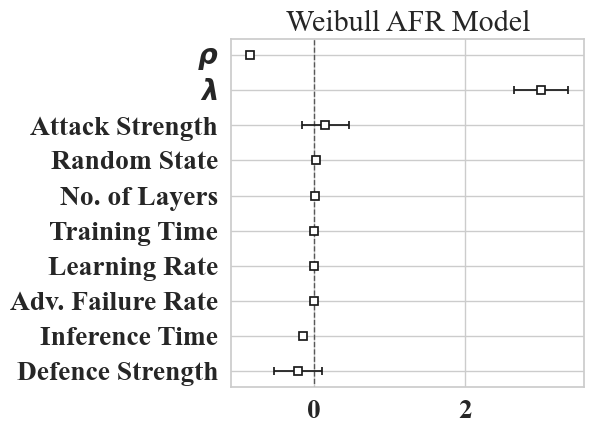

<lifelines.WeibullAFTFitter: fitted with 1500 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'adv_failures'
   number of observations = 1500
number of events observed = 1500
           log-likelihood = -5531.26
         time fit was run = 2023-09-29 11:13:25 UTC

---
                                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                                 
lambda_ adv_failure_rate                                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        atk_value                                           0.15       1.16       0.16            -0.16             0.46                 0.85                 1.58
        data.sample.random_state                            0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
        def_value                                          -0.21       0.81       0.16            -0.53             0.10                 0.59                 1.11
        model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
        model_layers                                        0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
        predict_time                                       -0.15       0.86       0.01            -0.17            -0.12                 0.84                 0.88
        train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        Intercept                                           3.00      20.18       0.18             2.65             3.36                14.14                28.79
rho_    Intercept                                          -0.84       0.43       0.02            -0.88            -0.80                 0.41                 0.45

                                                            cmp to      z      p   -log2(p)
param   covariate                                                                          
lambda_ adv_failure_rate                                      0.00 -39.62 <0.005        inf
        atk_value                                             0.00   0.95   0.34       1.56
        data.sample.random_state                              0.00   1.31   0.19       2.39
        def_value                                             0.00  -1.31   0.19       2.41
        model.art.pipeline.initialize.kwargs.optimizer.lr     0.00  -0.53   0.60       0.74
        model_layers                                          0.00   7.04 <0.005      38.88
        predict_time                                          0.00 -12.17 <0.005     110.86
        train_time                                            0.00  10.81 <0.005      88.14
        Intercept                                             0.00  16.56 <0.005     202.20
rho_    Intercept                                             0.00 -43.75 <0.005        inf
---
Concordance = 0.84
AIC = 11082.52
log-likelihood ratio test = 800.84 on 8 df
-log2(p) of ll-ratio test = 554.32

In [9]:
weibull_dict = {
    "Intercept: rho_": "$\\rho$",
    "Intercept: lambda_": "$\lambda$",
    "data.sample.random_state: lambda_": "Random State",
    "def_value: lambda_": "Defence Strength",
    "atk_value: lambda_": "Attack Strength",
    "train_time: lambda_": "Training Time",
    "predict_time: lambda_": "Inference Time",
    "adv_accuracy: lambda_": "Adv. Accuracy",
    "accuracy: lambda_": "Ben. Accuracy",
    "adv_fit_time: lambda_": "Adv. Fit Time",
    "adv_log_loss: lambda_": "Adv. Log Loss",
    "adv_failure_rate: lambda_": "Adv. Failure Rate",
    "failure_rate: lambda_": "Ben. Failure Rate",
    "model_layers: lambda_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr: lambda_" : "Learning Rate",
    "def_gen" : "Defence",
}

weibull_afr, wft = plot_aft(
    X_train,
    file = "weibull_aft.pdf",
    event_col = target,
    duration_col = duration_col,
    title = "Weibull AFR Model",
    mtype = "weibull",
    replacement_dict=weibull_dict,
)
wft.print_summary()
wft_scores = score_model(wft, X_train, X_test)


/tmp/ipykernel_773113/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


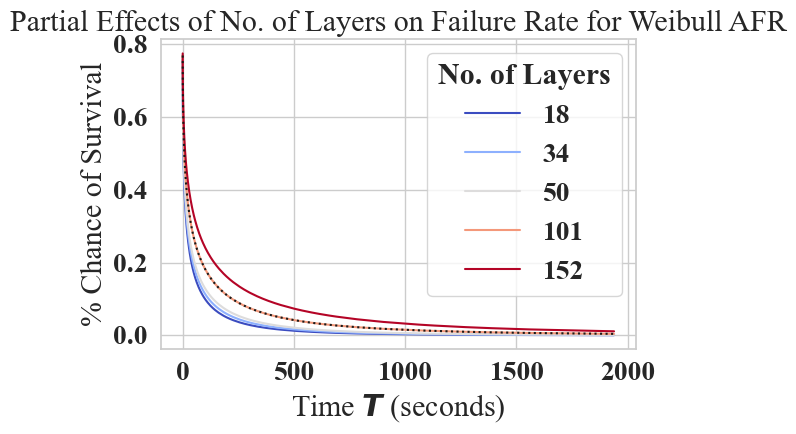

In [10]:
pareto_dict = {
    "model_layers=18": "18",
    "model_layers=34": "34",
    "model_layers=50": "50",
    "model_layers=101": "101",
    "model_layers=152": "152",
}
pareto_weibull = plot_partial_effects(
    file = "weibull_partial_effects.pdf", 
    aft = wft, 
    covariate_array="model_layers", 
    values_array=[18, 34, 50, 101, 152], 
    title="Partial Effects of No. of Layers on Failure Rate for Weibull AFR", 
    replacement_dict=pareto_dict, 
    ylabel="% Chance of Survival",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
    )

# weibull_accuracy = plot_partial_effects(
#     file = "weibull_partial_effect_accuracy.pdf",
#     aft = wft,
#     covariate_array = "accuracy",
#     values_array = [.9, .99, .999, .9999],
#     replacement_dict=weibull_dict,
#     title="Partial Effects of Benign Accuracy on Failure Rate",
#     ylabel="% Chance of Survival",
#     xlabel="Time $T$ (seconds)",
#     legend = {"title" : "Benign Accuracy"},
#     )
    
    

/home/cmeyers/deckard/env/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


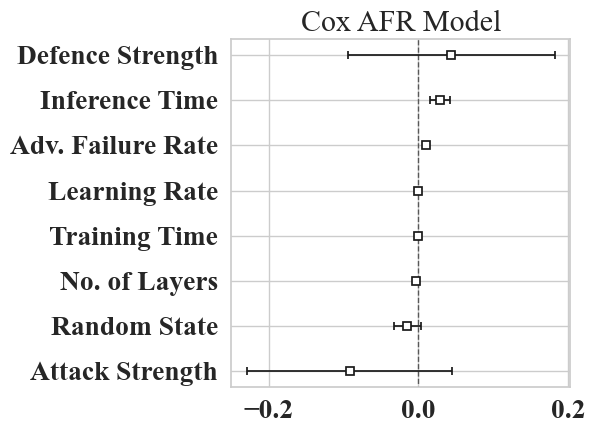

<lifelines.CoxPHFitter: fitted with 1500 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'adv_failures'
      baseline estimation = breslow
   number of observations = 1500
number of events observed = 1500
   partial log-likelihood = -7421.70
         time fit was run = 2023-09-29 11:13:28 UTC

---
                                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                 
train_time                                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
predict_time                                        0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
atk_value                                          -0.09       0.91       0.07            -0.23             0.05                 0.80                 1.05
def_value                                           0.04       1.05       0.07            -0.09             0.18                 0.91                 1.20
data.sample.random_state                           -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
adv_failure_rate                                    0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
model_layers                                       -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                                    cmp to     z      p   -log2(p)
covariate                                                                         
train_time                                            0.00 -4.25 <0.005      15.52
predict_time                                          0.00  4.21 <0.005      15.26
atk_value                                             0.00 -1.31   0.19       2.40
def_value                                             0.00  0.63   0.53       0.92
data.sample.random_state                              0.00 -1.57   0.12       3.10
adv_failure_rate                                      0.00 28.70 <0.005     599.53
model_layers                                          0.00 -5.20 <0.005      22.23
model.art.pipeline.initialize.kwargs.optimizer.lr     0.00 -0.13   0.90       0.15
---
Concordance = 0.92
Partial AIC = 14859.40
log-likelihood ratio test = 4105.41 on 8 df
-log2(p) of ll-ratio test = inf

/tmp/ipykernel_773113/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


<Figure size 640x480 with 0 Axes>

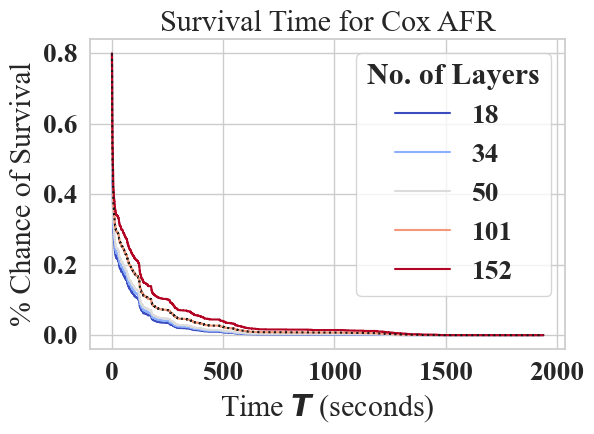

In [11]:

cox_dict = {
    "adv_failure_rate": "Adv. Failure Rate",
    "def_value" : "Defence Strength",
    "data.sample.random_state" : "Random State",
    "train_time" : "Training Time",
    "model_layers" : "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr" : "Learning Rate",
    "adv_accuracy" : "Adv. Accuracy",
    "adv_fit_time" : "Adv. Fit Time",
    "adv_log_loss" : "Adv. Log Loss",
    "predict_time" : "Inference Time",
    "accuracy" : "Ben. Accuracy",
    "failure_rate" : "Ben. Failure Rate",
    "atk_value" : "Attack Strength",
}

cox_afr, cft = plot_aft(
    X_train,
    file = "cox_aft.pdf",
    event_col = target,
    duration_col = duration_col,
    title = "Cox AFR Model",
    mtype = "cox",
    replacement_dict=cox_dict,
)
cox_scores = score_model(cft, X_train, X_test)
cft.print_summary()
cox_partial = plot_partial_effects(
    file = "cox_partial_effects.pdf",
    aft = cft,
    covariate_array = "model_layers",
    values_array = [18, 34, 50, 101, 152],
    replacement_dict=cox_dict,
    title="Survival Time for Cox AFR",
    ylabel="% Chance of Survival",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
)

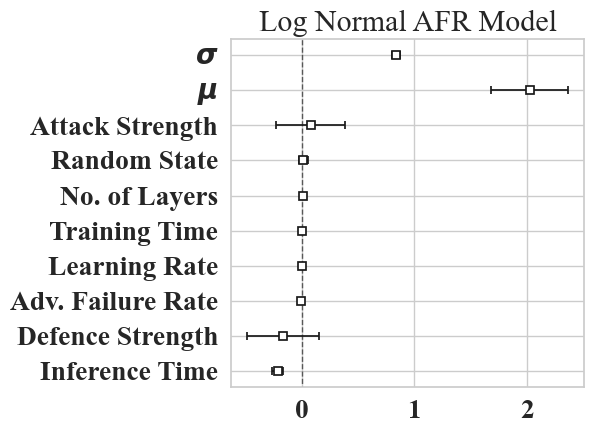

<lifelines.LogNormalAFTFitter: fitted with 1500 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'adv_failures'
   number of observations = 1500
number of events observed = 1500
           log-likelihood = -5374.54
         time fit was run = 2023-09-29 11:13:31 UTC

---
                                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                                 
mu_    adv_failure_rate                                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       atk_value                                           0.08       1.09       0.16            -0.22             0.39                 0.80                 1.48
       data.sample.random_state                            0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
       def_value                                          -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
       model.art.pipeline.initialize.kwargs.optimizer.lr  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       model_layers                                        0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
       predict_time                                       -0.21       0.81       0.02            -0.26            -0.16                 0.77                 0.85
       train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                                           2.02       7.54       0.17             1.68             2.36                 5.37                10.61
sigma_ Intercept                                           0.84       2.31       0.02             0.80             0.87                 2.23                 2.39

                                                           cmp to      z      p   -log2(p)
param  covariate                                                                          
mu_    adv_failure_rate                                      0.00 -31.84 <0.005     736.80
       atk_value                                             0.00   0.52   0.60       0.74
       data.sample.random_state                              0.00   0.83   0.41       1.30
       def_value                                             0.00  -0.98   0.32       1.62
       model.art.pipeline.initialize.kwargs.optimizer.lr     0.00  -0.06   0.95       0.07
       model_layers                                          0.00   7.13 <0.005      39.81
       predict_time                                          0.00  -8.37 <0.005      53.94
       train_time                                            0.00   7.13 <0.005      39.89
       Intercept                                             0.00  11.63 <0.005     101.36
sigma_ Intercept                                             0.00  45.86 <0.005        inf
---
Concordance = 0.84
AIC = 10769.08
log-likelihood ratio test = 925.72 on 8 df
-log2(p) of ll-ratio test = 643.78

/tmp/ipykernel_773113/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


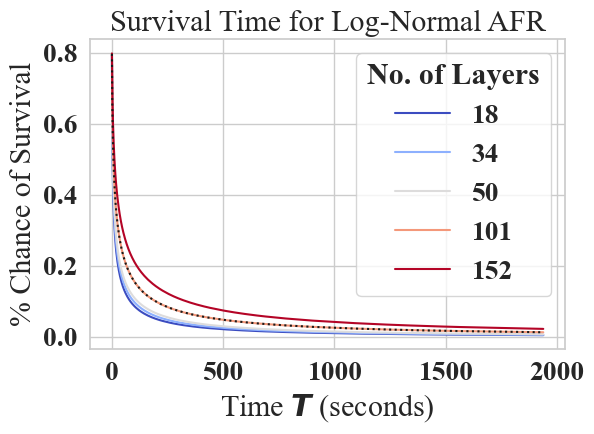

In [12]:
log_normal_dict = {
    "Intercept: sigma_": "$\sigma$",
    "Intercept: mu_": "$\mu$",
    "def_value: mu_": "Defence Strength",
    "atk_value: mu_": "Attack Strength",
    "train_time: mu_": "Training Time",
    "predict_time: mu_": "Inference Time",
    "adv_fit_time: mu_": "Adv. Fit Time",
    "model_layers: mu_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr: mu_" : "Learning Rate",
    "data.sample.random_state: mu_": "Random State",
    "adv_log_loss: mu_": "Adv. Log Loss",
    "adv_accuracy: mu_": "Adv. Accuracy",
    "accuracy: mu_": "Ben. Accuracy",
    "adv_failure_rate: mu_": "Adv. Failure Rate",
    "def_gen" : "Defence",
    "learning_rate: mu_" : "Learning Rate",
}

log_normal_graph, lnt = plot_aft(
    X_train,
    "log_normal_aft.pdf",
    target,
    duration_col,
    "Log Normal AFR Model",
    "log_normal",
    replacement_dict=log_normal_dict,
)
lnt_scores = score_model(lnt, X_train, X_test)
lnt.print_summary()
lnt_partial = plot_partial_effects(
    file = "log_normal_partial_effects.pdf",
    aft = lnt,
    covariate_array = "model_layers",
    values_array = [18, 34, 50, 101, 152],
    replacement_dict=log_normal_dict,
    title="Survival Time for Log-Normal AFR",
    ylabel="% Chance of Survival",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
)

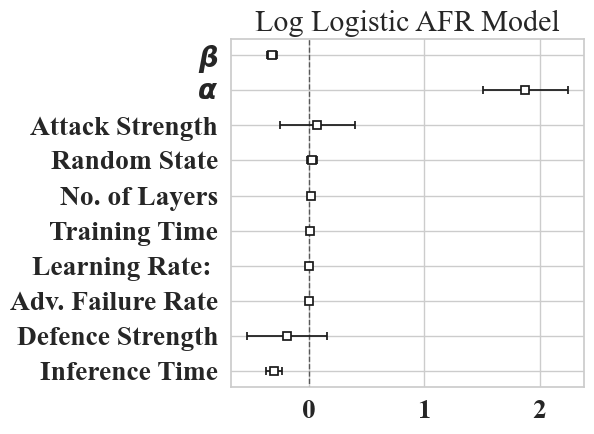

<lifelines.LogLogisticAFTFitter: fitted with 1500 total observations, 0 right-censored observations>
             duration col = 'adv_fit_time'
                event col = 'adv_failures'
   number of observations = 1500
number of events observed = 1500
           log-likelihood = -5426.84
         time fit was run = 2023-09-29 11:13:33 UTC

---
                                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                                 
alpha_ adv_failure_rate                                   -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
       atk_value                                           0.07       1.07       0.17            -0.26             0.40                 0.77                 1.49
       data.sample.random_state                            0.02       1.02       0.02            -0.02             0.06                 0.98                 1.07
       def_value                                          -0.19       0.82       0.18            -0.54             0.15                 0.58                 1.16
       model.art.pipeline.initialize.kwargs.optimizer.lr   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       model_layers                                        0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
       predict_time                                       -0.31       0.74       0.04            -0.38            -0.24                 0.69                 0.79
       train_time                                          0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
       Intercept                                           1.88       6.54       0.19             1.51             2.25                 4.52                 9.46
beta_  Intercept                                          -0.32       0.72       0.02            -0.36            -0.28                 0.69                 0.75

                                                           cmp to      z      p   -log2(p)
param  covariate                                                                          
alpha_ adv_failure_rate                                      0.00 -26.62 <0.005     516.20
       atk_value                                             0.00   0.42   0.67       0.58
       data.sample.random_state                              0.00   0.91   0.36       1.47
       def_value                                             0.00  -1.11   0.27       1.90
       model.art.pipeline.initialize.kwargs.optimizer.lr     0.00   0.03   0.97       0.04
       model_layers                                          0.00   7.88 <0.005      48.13
       predict_time                                          0.00  -8.73 <0.005      58.49
       train_time                                            0.00   6.12 <0.005      30.02
       Intercept                                             0.00   9.97 <0.005      75.31
beta_  Intercept                                             0.00 -15.46 <0.005     176.59
---
Concordance = 0.82
AIC = 10873.68
log-likelihood ratio test = 961.93 on 8 df
-log2(p) of ll-ratio test = 669.73

{'train_score': -3.617893432558881, 'test_score': -3.971188942813805}


/tmp/ipykernel_773113/12050270.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  pareto.set_yticklabels(labels)


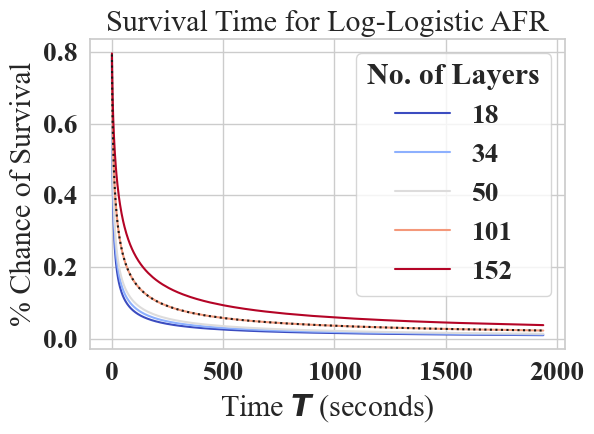

In [13]:

log_logistic_dict = {
    "Intercept: beta_": "$\\beta$",
    "Intercept: alpha_": "$\\alpha$",
    "data.sample.random_state: alpha_": "Random State",
    "def_value: alpha_": "Defence Strength",
    "atk_value: alpha_": "Attack Strength",
    "train_time: alpha_": "Training Time",
    "predict_time: alpha_": "Inference Time",
    "adv_accuracy: alpha_": "Adv. Accuracy",
    "accuracy: alpha_": "Ben. Accuracy",
    "adv_fit_time: alpha_": "Adv. Fit Time",
    "model_layers: alpha_": "No. of Layers",
    "model.art.pipeline.initialize.kwargs.optimizer.lr" : "Learning Rate",
    "adv_failure_rate: alpha_": "Adv. Failure Rate",
    "alpha_" : "",

}

log_logistic_graph, llt = plot_aft(
    X_train,
    "log_logistic_aft.pdf",
    target,
    duration_col,
    "Log Logistic AFR Model",
    "log_logistic",
    replacement_dict=log_logistic_dict,
)
llt.print_summary()
llt_scores = score_model(llt, X_train, X_test)
print(llt_scores)
llt_partial = plot_partial_effects(
    file = "log_logistic_partial_effects.pdf",
    aft = llt,
    covariate_array = "model_layers",
    values_array = [18, 34, 50, 101, 152],
    replacement_dict=log_logistic_dict,
    title="Survival Time for Log-Logistic AFR",
    ylabel="% Chance of Survival",
    xlabel="Time $T$ (seconds)",
    legend_kwargs={"title" : "No. of Layers", "labels" : ["18", "34", "50", "101", "152"]},
       
)

In [14]:
np.mean(llt.predict_median(X_train))

8.62393284274078

In [15]:
aft_dict = {
    "Weibull": wft,
    "LogNormal": lnt,
    "LogLogistic": llt,
    # "Cox": cft,
}

score_list = [
    wft_scores,
    lnt_scores,
    llt_scores,
    # cft_scores,
]
aft_data = pd.DataFrame()
aft_data.index.name = "Model"
aft_data.index = aft_dict.keys()
aft_data["AIC"] = [x.AIC_ if not isinstance(x, CoxPHFitter) else np.nan for x in aft_dict.values() ]
aft_data["Concordance"] = [x.concordance_index_ for x in aft_dict.values()]
aft_data["BIC"] = [x.AIC_ if not isinstance(x, CoxPHFitter) else np.nan for x in aft_dict.values()]
aft_data['Train LL'] = [x['train_score'] for x in score_list]
aft_data['Test LL'] = [x['test_score'] for x in score_list]
aft_data['Mean ST'] = [x.predict_expectation(X_train).mean() for x in aft_dict.values()]
aft_data['Median ST'] = [x.predict_median(X_train).median() for x in aft_dict.values()]
aft_data = aft_data.round(2)
aft_data.to_csv(FOLDER / "aft_comparison.csv")
logger.info(f"Saved AFT comparison to {FOLDER / 'aft_comparison.csv'}")
aft_data = aft_data.round(2,)
aft_data.to_latex(FOLDER / "aft_comparison.tex",  float_format="%.2f", label = "tab:mnist", caption="Comparison of AFR Models on the MNIST dataset.")
aft_data


,AIC,Concordance,BIC,Train LL,Test LL,Mean ST,Median ST
Weibull,11082.52,0.84,11082.52,-3.69,-4.00,71.53,10.23
LogNormal,10769.08,0.84,10769.08,-3.58,-3.92,122.81,7.79
LogLogistic,10873.68,0.82,10873.68,-3.62,-3.97,NaN,6.62
